In [3]:
from pyomo.environ import (
    SolverFactory,
    AbstractModel,
    Param,
    Set,
    Var,
    Objective,
    Constraint,
)
from pyomo.core import NonNegativeIntegers, PositiveIntegers, Any, NonNegativeReals, Binary  # type: ignore
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple

Point = Tuple[float, float]
Points = list[Point]

solver = SolverFactory("glpk")

# $p$-center example

### Definitions
$$
\begin{aligned}
  I &= \text{set of demand points indexed by } i \\
  J &= \text{set of potential facilities, indexed by } j \\
  p &= \text{number of facilities to select} \\
  d_{ij} &= \text{distance between demand point} i \text{and potential facility } j \\
  z_i &= \begin{cases}
    1 & \text{if demand point $i$ is assigned a facility} \\
    0 & \text{otherwise}
  \end{cases} \\
  x_j &= \begin{cases}
    1 & \text{if facility $j$ is selected} \\
    0 & \text{otherwise}
  \end{cases} \\
  y_{ij} &= \begin{cases}
    1 & \text{if demand point $i$ is assigned to facility $j$} \\
    0 & \text{otherwise}
  \end{cases} \\
  W &= \text{maximum distance between any demand point and selected facility}
\end{aligned}
$$

### Objective and Constraints
$$
\text{Minimize } W \\
$$

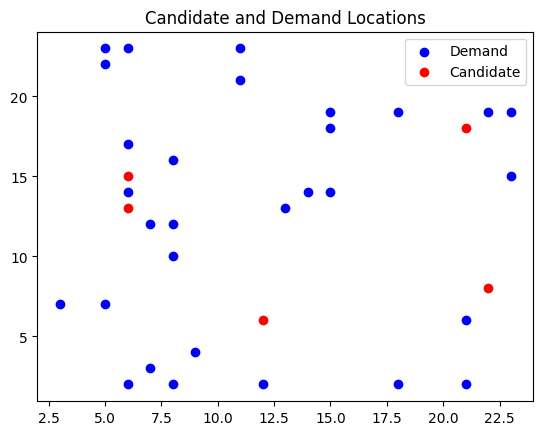

In [18]:
demands_df = pd.read_csv("Water Optimization/clustering/D_data.csv")
facilities_df = pd.read_csv("Water Optimization/clustering/C_data.csv")

fig, ax = plt.subplots()

DEMAND_POINTS: Points = list(zip(demands_df.iloc[:, 0], demands_df.iloc[:, 1]))
POTENTIAL_FACILITIES: Points = list(
    zip(facilities_df.iloc[:, 0], facilities_df.iloc[:, 1])
)

ax.scatter([x for x, _ in DEMAND_POINTS], [y for _, y in DEMAND_POINTS], c="blue")
ax.scatter(
    [x for x, _ in POTENTIAL_FACILITIES], [y for _, y in POTENTIAL_FACILITIES], c="red"
)
ax.set_title("Candidate and Demand Locations")

ax.legend(["Demand", "Candidate"])

### Pyomo Model and Utilities

In [57]:
def create_data(
    max_facilities: int = 1,
    demand_points: Points = DEMAND_POINTS,
    potential_facilities: Points = POTENTIAL_FACILITIES,
) -> dict:
    assert max_facilities <= len(potential_facilities)

    return {
        None: {
            "max_facilities": {None: max_facilities},
            "D": {None: list(range(len(demand_points)))},
            "demand_points": {i: d for i, d in enumerate(demand_points)},
            "F": {None: list(range(len(potential_facilities)))},
            "potential_facilities": {i: f for i, f in enumerate(potential_facilities)},
        }
    }


def distance(c: Point, d: Point) -> float:
    return np.sqrt((c[0] - d[0]) ** 2 + (c[1] - d[1]) ** 2)


model = AbstractModel()

model.max_facilities = Param(within=PositiveIntegers)  # p

# TODO: Strongly type any
model.D = Set(domain=NonNegativeIntegers)  # indices for I
model.demand_points = Param(model.D, within=Any)  # I

model.F = Set(domain=NonNegativeIntegers)  # indices for J
model.potential_facilities = Param(model.F, within=Any)  # J

model.demand_facility_distance = Param(
    model.D,
    model.F,
    default=lambda model, d, f: distance(
        model.demand_points[d], model.potential_facilities[f]
    ),
    within=NonNegativeReals,
)  # d_ij

model.is_facility_selected = Var(model.F, within=Binary)  # x_j
model.is_demand_facility_assigned = Var(model.D, model.F, within=Binary)  # y_ij

model.max_assigned_distance = Var(within=NonNegativeReals)  # W

# 3.10: Minimize maximum distance between demand points and their assigned facilities
model.minimize_max_distance = Objective(expr=lambda model: model.max_assigned_distance)

# 3.11: Ensures we select only p facilities
model.limit_facilities = Constraint(
    rule=lambda model: sum(model.is_facility_selected[f] for f in model.F)
    == model.max_facilities
)

# 3.12: Ensures each demand point is assigned to exactly 1 facility
model.ensure_assignment = Constraint(
    model.D,
    rule=lambda model, d: sum(model.is_demand_facility_assigned[d, f] for f in model.F)
    == 1,
)

# 3.13: Ensures demand nodes are assigned only to selected facilities
model.assign_open = Constraint(
    model.D,
    model.F,
    rule=lambda model, d, f: model.is_demand_facility_assigned[d, f]
    - model.is_facility_selected[f]
    <= 0,
)

# 3.14: Defines the lower bound on the maximum distance
model.lower_bound = Constraint(
    model.D,
    rule=lambda model, d: model.max_assigned_distance
    - sum(
        model.demand_facility_distance[d, f] * model.is_demand_facility_assigned[d, f]
        for f in model.F
    )
    >= 0,
)


def plot_model(
    instance, demand_points: Points, potential_facilities: Points, title: str = ""
) -> None:
    if len(demand_points) == 0:
        return

    selected_facilities = {
        f: instance.potential_facilities[f]
        for f in instance.F
        for d in instance.D
        if instance.is_demand_facility_assigned[d, f].value == 1
    }

    fig, ax = plt.subplots()

    ax.scatter(*zip(*potential_facilities), c="red", label="Potential facilities")
    ax.scatter(*zip(*demand_points), c="blue", label="Demand points")
    ax.scatter(
        *zip(*selected_facilities.values()), c="green", label="Selected facilities"
    )

    ax.legend(["Unselected facilities", "Demand points", "Selected facilities"])
    ax.set_title(
        title
        or f"$p$-center solution for $p={instance.max_facilities.value}$ and $|I|={len(demand_points)}$"
    )
    ax.axis("equal")

    max_facility = 0
    # TODO: Max facility only goes by assignment, not by max distance
    for f in instance.F:
        if len(
            [
                d
                for d in instance.D
                if instance.is_demand_facility_assigned[d, f].value == 1
            ]
        ) > len(
            [
                d
                for d in instance.D
                if instance.is_demand_facility_assigned[d, max_facility].value == 1
            ]
        ):
            max_facility = f

    circle = plt.Circle(
        instance.potential_facilities[max_facility],
        instance.max_assigned_distance.value,
        color="g",
        fill=False,
    )

    ax.add_patch(circle)

    for f in selected_facilities.keys():
        linked_demand_points = [
            instance.demand_points[d]
            for d in instance.D
            if instance.is_demand_facility_assigned[d, f].value == 1
        ]

        for d in linked_demand_points:
            ax.plot(*zip(instance.potential_facilities[f], d), c="grey")

    plt.savefig(
        f"Water Optimization/clustering/Example p-center Solutions/example_p_center_{instance.max_facilities.value}_facilities.svg"
    )


def run_model(
    max_facilities: int,
    demand_points: Points,
    potential_facilities: Points,
    print_info=False,
) -> AbstractModel:
    instance = model.create_instance(
        create_data(max_facilities, demand_points, potential_facilities)
    )
    results = solver.solve(instance)

    # print(results)
    if print_info:
        for f in instance.F:
            if instance.is_facility_selected[f].value == 1:
                print(
                    f"Facility {instance.potential_facilities[f]} links {len([d for d in instance.D if instance.is_demand_facility_assigned[d, f].value == 1])} demand points."
                )
        print(f"Max distance: {instance.max_assigned_distance.value}")

    plot_model(instance, demand_points, potential_facilities)
    return instance

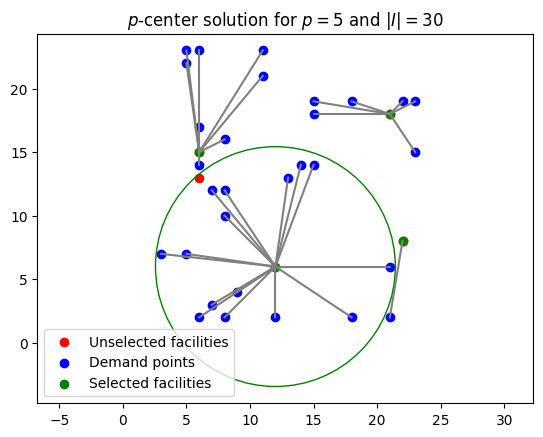

In [53]:
run_model(5, DEMAND_POINTS, POTENTIAL_FACILITIES)

## Ann's Variation
- Run $p$-center problem, recording the number of demand points satisfied and maximum distance for each selected facility.
- Remove all the demand points **within range** (not just assigned to) the selected facility that serves the most demand points.
- Re-run p-center with remaining points and remaining facilities.
- Repeat until $p = 0$

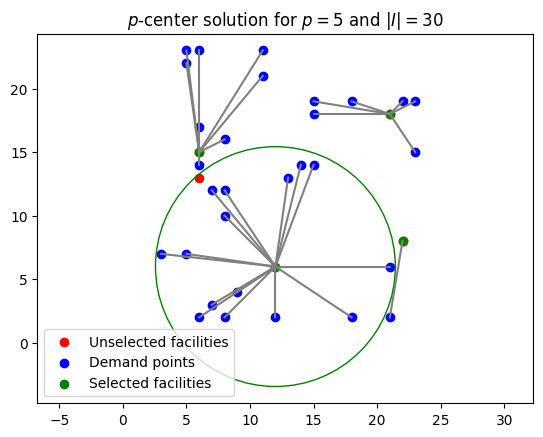

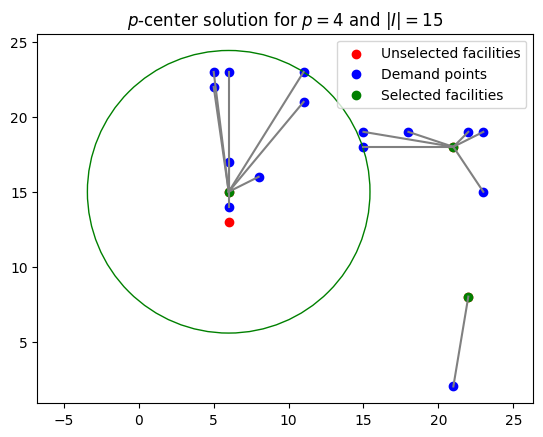

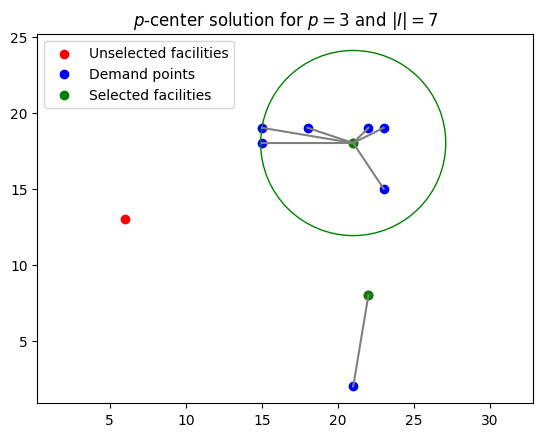

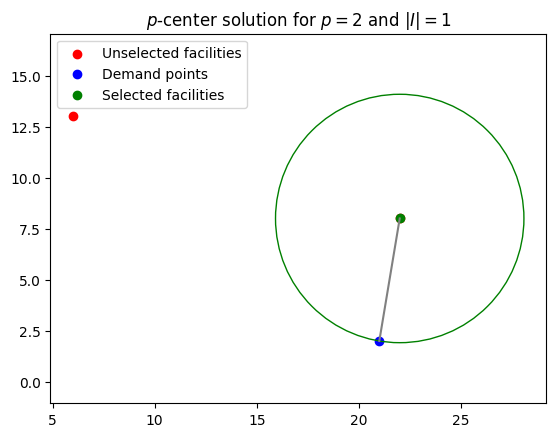

In [58]:
p = 5
# demand_points = [(np.random.rand(), np.random.rand()) for _ in range(100)]
# potential_facilities = [(np.random.rand(), np.random.rand()) for _ in range(5)]
demand_points = DEMAND_POINTS
potential_facilities = POTENTIAL_FACILITIES

assignments: list[dict[Point, Points]] = [] * p

while p > 0:
    instance = run_model(p, demand_points, potential_facilities)

    facility_i_to_num_demand = {
        f: len(
            [
                d
                for d in instance.D
                if instance.is_demand_facility_assigned[d, f].value == 1
            ]
        )
        for f in instance.F
    }
    sorted_facility_i_s = sorted(
        facility_i_to_num_demand, key=facility_i_to_num_demand.get, reverse=True
    )
    max_facility_i = sorted_facility_i_s[0]
    demand_points_i_to_distance = {
        d: instance.demand_facility_distance[d, max_facility_i]
        for d in instance.D
        if instance.is_demand_facility_assigned[d, max_facility_i].value == 1
    }

    with open(
        f"Water Optimization/clustering/Example p-center Solutions/example_p_center_{p}_data.txt",
        "w",
    ) as file:
        file.write(f"p = {p}; |I| = {len(demand_points)}\n\n")
        for f in sorted_facility_i_s:
            facility_demand_points = [
                instance.demand_points[d]
                for d in instance.D
                if instance.is_demand_facility_assigned[d, f].value == 1
            ]

            file.write(
                f"J_j = {instance.potential_facilities[f][0]}, {instance.potential_facilities[f][1]}; |y_ij| = {len(facility_demand_points)}\n"
            )
            for d in facility_demand_points:
                file.write(f"{d[0]}, {d[1]}\n")
            file.write("\n")

    max_facility_demand_points = [
        instance.demand_points[d] for d in demand_points_i_to_distance.keys()
    ]

    potential_facilities = list(
        set(potential_facilities) - set([instance.potential_facilities[max_facility_i]])
    )
    demand_points = list(set(demand_points) - set(max_facility_demand_points))

    p -= 1